## Predict features' categories and evaluate performance (snack lines)

In [1]:
import os
import openai
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay
import sklearn
from sklearn.metrics import mean_squared_error,mean_absolute_error,f1_score,classification_report
import numpy as np
import matplotlib.pyplot as plt
import random
openai.api_key = os.getenv("OPENAI_API_KEY")

## Get predictions

In [2]:
df=pd.read_csv("../../input_data/complete_file.csv")


preprompt="Consider this situation and answer the question that follows:\nSituation: "

df=df.assign(statement=preprompt+df.scenario+"\nQuestion: ")

df=df.loc[(df.study=='lines') & (df.condition.isin(['adult','snack2'])),:].reset_index(drop=True)

In [3]:
f2="How much longer will the kid in the front of the line have to wait if this kid cuts?  Answer with one of the following: same amount of time, a little longer, a lot longer."
f3="If she doesn't cut in line, how bad will things be for her? Answer with one of the following: she’ll be fine, a little bad for her, really bad for her"
f1a="Does this kid want to cut the line to get a snack or for some other reason? Answer with one of the following: get a snack, or some other reason."
f1b="Has this person already waited the appropriate amount of time in line to get their snack? Answer with one of the following: they have waited the appropriate amount of time, they have waited a little less than they should have, or they haven’t waited at all."
f1c="Compared to the snack that the other kids got, how good is what this kid got? Answer with one of the following: much worse, worse, or the same."

In [4]:
df=df.assign(feat2_cat=np.where(df.feature2<=3,"1. same amount of time",
                                        np.where(df.feature2<=5,"2. a little longer","3. a lot longer")))
df=df.assign(feat3_cat=np.where(df.feature3<=3,"1. she'll be fine",
                                        np.where(df.feature3<=5,"2. a little bad","3. really bad")))
df=df.assign(feat1b_cat=np.where(df.feature1b>=1,"1. appropriate",
                                        np.where(df.feature1b==-2,"2. less","3. haven’t waited")))
df=df.assign(feat1c_cat=np.where(df.feature1c<=-1,"1. much worse",
                                        np.where(df.feature1c<=1,"2. worse","3. the same")))

In [5]:
for i,d in df.iterrows():
    input_prompt=d['statement']+f2
    completion = openai.Completion.create(engine="text-davinci-002", prompt=input_prompt,temperature=0,max_tokens=60)
    df.loc[i,'first_response']=completion.choices[0].text

    
    
    input_2=d['statement']+"\nQuestion: "+f3+"\n"
    second_response = openai.Completion.create(engine="text-davinci-002", prompt=input_2,temperature=0,max_tokens=60)
    df.loc[i,'second_response']=second_response.choices[0].text

    input_3=d['statement']+"\nQuestion: "+f1b+"\n"
    third_response = openai.Completion.create(engine="text-davinci-002", prompt=input_3,temperature=0,max_tokens=60)
    df.loc[i,'third_response']=third_response.choices[0].text
    input_final=input_3
    resp_final=df.loc[i,'third_response']

    
    
    input_4=d['statement']+"\nQuestion: "+f1c+"\n"
    fourth_response = openai.Completion.create(engine="text-davinci-002", prompt=input_4,temperature=0,max_tokens=60)
    df.loc[i,'fourth_response']=fourth_response.choices[0].text
    input_final=input_4
    resp_final=df.loc[i,'fourth_response']

## Assign categories

In [6]:
df=df.assign(predf2=
    np.where(df.first_response.str.lower().str.contains('a lot longer'),'3. a lot longer',
    np.where(df.first_response.str.lower().str.contains('a little longer'),'2. a little longer',
    np.where(df.first_response.str.lower().str.contains('same amount of time'),
             '1. same amount of time',"None"))))

df=df.assign(predf3=
    np.where(df.second_response.str.lower().str.contains("fine"),"1. she'll be fine",
    np.where(df.second_response.str.lower().str.contains('little bad'),'2. a little bad',
    np.where(df.second_response.str.lower().str.contains('really bad'),
             '3. really bad',"None"))))

df=df.assign(predf1b=
    np.where(df.third_response.str.lower().str.contains("appropriate"),"1. appropriate",
    np.where(df.third_response.str.lower().str.contains('less'),'2. less',
    np.where(df.third_response.str.lower().str.contains("haven’t waited|has not waited"),
             "3. haven’t waited","None"))))

df=df.assign(predf1c=
    np.where(df.fourth_response.str.lower().str.contains("much worse"),"1. much worse",
    np.where(df.fourth_response.str.lower().str.contains('worse'),'2. worse',
    np.where(df.fourth_response.str.lower().str.contains("same"),
             "3. the same","None"))))

df=df.assign(gpt_feature2=
    np.where(df.first_response.str.lower().str.contains('a lot longer'),7,
    np.where(df.first_response.str.lower().str.contains('a little longer'),4,
    np.where(df.first_response.str.lower().str.contains('same amount of time'),
             1,None))))

df=df.assign(gpt_feature3=
    np.where(df.second_response.str.lower().str.contains("fine"),1,
    np.where(df.second_response.str.lower().str.contains('little bad'),4,
    np.where(df.second_response.str.lower().str.contains('really bad'),
             7,None))))

df=df.assign(gpt_feature1b=
    np.where(df.third_response.str.lower().str.contains("appropriate"),1,
    np.where(df.third_response.str.lower().str.contains('less'),-2,
    np.where(df.third_response.str.lower().str.contains("haven’t waited|has not waited"),
             -3,None))))

df=df.assign(gpt_feature1c=
    np.where(df.fourth_response.str.lower().str.contains("much worse"),-3,
    np.where(df.fourth_response.str.lower().str.contains('worse'),0,
    np.where(df.fourth_response.str.lower().str.contains("same"),
             3,None))))

df=df.assign(gpt_feature1b=np.where(df.feature1b.isna(),None,df.gpt_feature1b))
df=df.assign(gpt_feature1c=np.where(df.feature1c.isna(),None,df.gpt_feature1c))

## Assign random features

In [7]:

random.seed(0)

df.shape

l = [random.randint(0,2) for i in range(df.shape[0])]

df=df.assign(feat2_rand=l)

df=df.assign(feat2_rands=
    np.where(df.feat2_rand==0,'3. a lot longer',
    np.where(df.feat2_rand==1,'2. a little longer',
    np.where(df.feat2_rand==2,'1. same amount of time',"None"))))



l = [random.randint(0,2) for i in range(df.shape[0])]

df=df.assign(feat3_rand=l)

df=df.assign(feat3_rands=
    np.where(df.feat2_rand==0,'3. really bad',
    np.where(df.feat2_rand==1,'2. a little bad',
    np.where(df.feat2_rand==2,"1. she'll be fine","None"))))

l = [random.randint(0,2) for i in range(df.shape[0])]

df=df.assign(feat1b_rand=l)

df=df.assign(feat1b_rands=
    np.where(df.feat1b_rand==0,'1. appropriate',
    np.where(df.feat1b_rand==1,'2. less',
    np.where(df.feat1b_rand==2,'3. haven’t waited',"None"))))

l = [random.randint(0,2) for i in range(df.shape[0])]

df=df.assign(feat1c_rand=l)

df=df.assign(feat1c_rands=
    np.where(df.feat1c_rand==0,'1. much worse',
    np.where(df.feat1c_rand==1,'2. worse',
    np.where(df.feat1c_rand==2,'3. the same',"None"))))

## Evaluate

### Feature 2

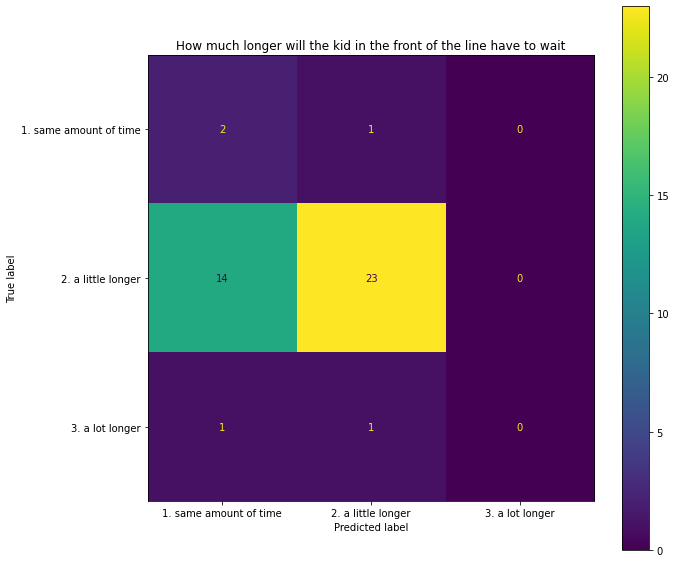

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(df.feat2_cat,df.predf2,ax=ax)
plt.title("How much longer will the kid in the front of the line have to wait")
plt.show()

In [9]:
gen=classification_report(df.feat2_cat,df.predf2,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Features prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Features prediction
F1:  66.79
Accuracy:  59.52


/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [10]:
gen=classification_report(df.feat2_cat,df.feat2_rands,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Random prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Random prediction
F1:  48.85
Accuracy:  38.10


### Feature 3

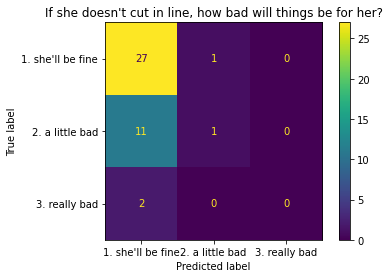

In [11]:
ConfusionMatrixDisplay.from_predictions(df.feat3_cat,df.predf3)
plt.title("If she doesn't cut in line, how bad will things be for her?")
plt.show()

In [12]:
gen=classification_report(df.feat3_cat,df.predf3,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Features prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Features prediction
F1:  57.02
Accuracy:  66.67


/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [13]:
gen=classification_report(df.feat3_cat,df.feat3_rands,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Random prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Random prediction
F1:  21.59
Accuracy:  19.05


### Feature 1b

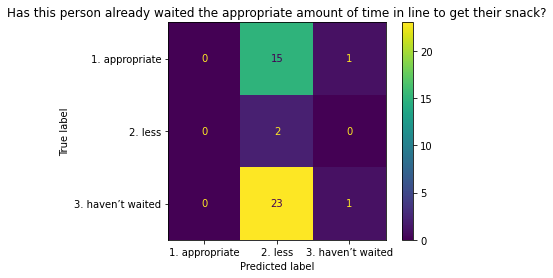

In [14]:
ConfusionMatrixDisplay.from_predictions(df.feat1b_cat,df.predf1b)
plt.title("Has this person already waited the appropriate amount of time in line to get their snack?")
plt.show()

In [15]:
gen=classification_report(df.feat1b_cat,df.predf1b,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Features prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Features prediction
F1:  4.85
Accuracy:  7.14


/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [16]:
gen=classification_report(df.feat1b_cat,df.feat1b_rands,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Random prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Random prediction
F1:  40.95
Accuracy:  35.71


### Feature 1c

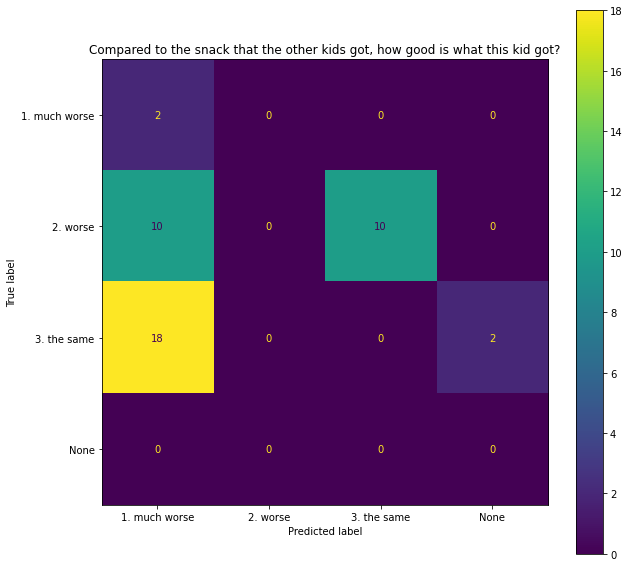

In [17]:
fig, ax1 = plt.subplots(figsize=(10,10))
cm2=ConfusionMatrixDisplay.from_predictions(df.feat1c_cat,df.predf1c,ax=ax1)
plt.title("Compared to the snack that the other kids got, how good is what this kid got?")
plt.show()

In [18]:
gen=classification_report(df.feat1c_cat,df.predf1c,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Features prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Features prediction
F1:  0.60
Accuracy:  4.76


/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [19]:
gen=classification_report(df.feat1c_cat,df.feat1c_rands,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Random prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Random prediction
F1:  28.23
Accuracy:  26.19


In [20]:
df.to_csv("../../outputs/analysis/features/snacks_features.csv",index=False)

In [153]:
#snacks=df.loc[:,['context', 'condition', 'study', 'human.response', 'feature1',
#       'feature2', 'gpt_feature2','feature3', 'gpt_feature3','feature1b','gpt_feature1b', 'feature1c','gpt_feature1c', 'prompt',
#       'prompt_short', 'prompt_long']]

#snacks.to_csv("./snack_features_categorical.csv",index=False)